In [9]:
import polars as pl
import numpy as np
import warnings
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
import polars.selectors as cs

warnings.filterwarnings("ignore")

# commission = 0.25 / 10000.0
commission = 0

In [10]:
data_hour = pl.read_parquet('data/futures_1h.parquet')
data_hour

symbol,interval,open_time,open,high,low,close,volume,close_time,quote_volume,count,taker_buy_volume,taker_buy_quote_volume
str,str,datetime[ns],f64,f64,f64,f64,f64,datetime[ns],f64,i64,f64,f64
"""1000000BOBUSDT""","""1h""",2025-06-05 08:00:00,0.11042,0.11726,0.08926,0.10968,1.59170454e8,2025-06-05 08:59:59.999,1.7045e7,133739,8.0254192e7,8.5767e6
"""1000000BOBUSDT""","""1h""",2025-06-05 09:00:00,0.10961,0.1125,0.1025,0.1058,1.10162144e8,2025-06-05 09:59:59.999,1.1771e7,119310,5.6143605e7,6.0104e6
"""1000000BOBUSDT""","""1h""",2025-06-05 10:00:00,0.10577,0.1069,0.09995,0.10078,7.095683e7,2025-06-05 10:59:59.999,7.3005e6,83184,3.2361444e7,3.3351e6
"""1000000BOBUSDT""","""1h""",2025-06-05 11:00:00,0.10079,0.10282,0.09331,0.09613,6.7370274e7,2025-06-05 11:59:59.999,6.6192e6,71763,3.3054235e7,3.2523e6
"""1000000BOBUSDT""","""1h""",2025-06-05 12:00:00,0.09613,0.1025,0.09507,0.10166,5.477255e7,2025-06-05 12:59:59.999,5.4442e6,64034,2.949649e7,2.9333e6
…,…,…,…,…,…,…,…,…,…,…,…,…
"""ZECUSDT""","""1h""",2025-07-05 05:00:00,39.57,39.65,39.42,39.63,3070.263,2025-07-05 05:59:59.999,121279.9437,1374,1636.985,64675.36647
"""ZECUSDT""","""1h""",2025-07-05 06:00:00,39.64,39.98,39.53,39.81,4658.461,2025-07-05 06:59:59.999,185269.10762,2391,2804.443,111502.37163
"""ZECUSDT""","""1h""",2025-07-05 07:00:00,39.82,39.87,39.62,39.78,3043.456,2025-07-05 07:59:59.999,120947.16987,2124,1535.016,61007.75327


In [11]:
result_hour = pl.read_parquet('./kline_1d_df.parquet')
result_hour = result_hour.sort('open_time','jj_code')
result_hour = result_hour.rename({"jj_code": "symbol"})

In [12]:
result_hour = data_hour.filter(
    (pl.col('open_time') >= pl.datetime(2022,1,1))
)
result_hour = result_hour.sort('close_time', 'symbol')

In [13]:
factors = result_hour.with_columns(
    ((pl.col('close') - pl.col('close').shift(1))/pl.col('close').shift(1)).over('symbol').alias('ret')
)
factors = factors.with_columns(
    (pl.col('ret').abs().rolling_sum(window_size=10)).over('symbol').alias('ret_sum')
)
factors = factors.with_columns(
    (pl.col('quote_volume').rolling_sum(window_size=10)).over('symbol').alias('volume_sum')
)
factors = factors.with_columns(
    (pl.col('ret_sum')/pl.col('volume_sum')).over('symbol').alias('amihud_ratio')
)
factors = factors.with_columns(
    (pl.col('amihud_ratio')+1).log().alias('amihud_ratio')
)
factors = factors.with_columns(
    pl.when(pl.col('ret') < 0).then(pl.col('ret')).otherwise(0).alias('ret_down'))
factors = factors.with_columns(
    pl.col('ret_down').pow(2).alias('ret_down_sq'))
factors = factors.with_columns(
    (pl.col('ret_down_sq') / pl.col('ret').pow(2)).alias('ret_down_ratio'))

In [14]:
factors = factors.with_columns(
    (pl.col('open_time').dt.round('1d')).alias('day')
)
factors = factors.set_sorted('open_time')
factors = factors.set_sorted('day')
factors = factors.group_by(['day','symbol']).agg(
    pl.col('open_time').last(),
    pl.col('close_time').last(),
    pl.col('close').last(),
    pl.col('volume').sum(),
    pl.col('ret').ewm_mean(span=24).last(),
    pl.col('ret_down_ratio').last()
)

result_hour = result_hour.with_columns(
    (pl.col('open_time').dt.round('1d')).alias('day')
)
result_hour = result_hour.set_sorted('open_time')
result_hour = result_hour.set_sorted('day')
result_hour = result_hour.group_by(['day','symbol']).agg(
    pl.col('open_time').last(),
    pl.col('close_time').last(),
    pl.col('open').last(),
    pl.col('high').last(),
    pl.col('low').last(),
    pl.col('close').last(),
    pl.col('volume').sum(),
    pl.col('quote_volume').sum(),
    pl.col('taker_buy_volume').sum()
)

因子1：CLOSE
以收盘价作为因子数值，这个因子类似于市值因子

In [15]:
close = result_hour[["open_time", "symbol", "close"]].pivot(index="open_time", columns="symbol", values="close").sort("open_time")
volume = result_hour[["open_time", "symbol", "volume"]].pivot(index="open_time", columns="symbol", values="volume").sort("open_time")
columns = close.columns[1:]

# 因子写在这里：
factors = factors[["open_time", "symbol", 'ret_down_ratio']].pivot(index="open_time", columns="symbol", values="ret_down_ratio").sort("open_time")

# 因子未来收益率：
ret = close.clone()
ret[columns] = ret[columns].shift(-1) / ret[columns] - 1

# 对齐column
ret = ret[factors.columns] 
t = factors[["open_time"]] 

# 对齐open_time
ret = ret.join(t, how="inner", on=["open_time"]).sort(by=["open_time"]) 
factors = factors.sort(by=["open_time"])

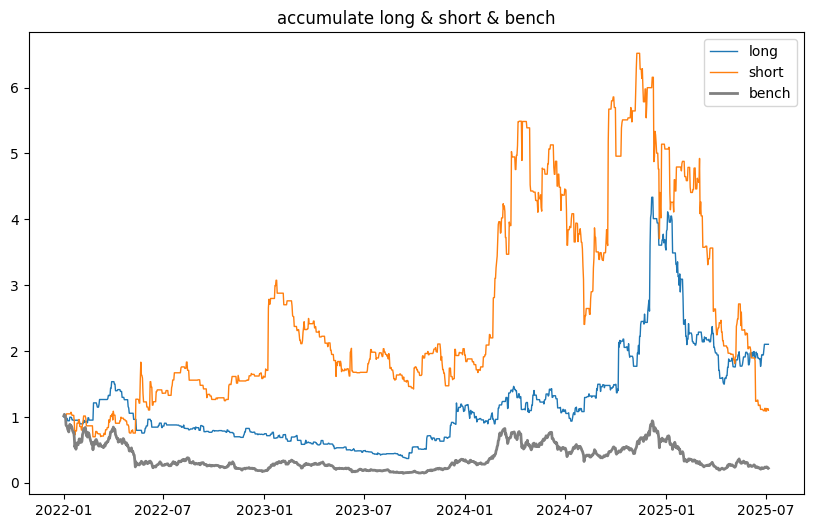

long: 
ann_return = 11.4044  sharpe = 3.06  maxdd = 0.7594  calmar_ratio = 15.0174  

short: 
ann_return = 11.6861  sharpe = 2.3852  maxdd = 0.8327  calmar_ratio = 14.0341  

bench: 
ann_return = 0.4692  sharpe = 0.1025  maxdd = 0.8597  calmar_ratio = 0.5458  



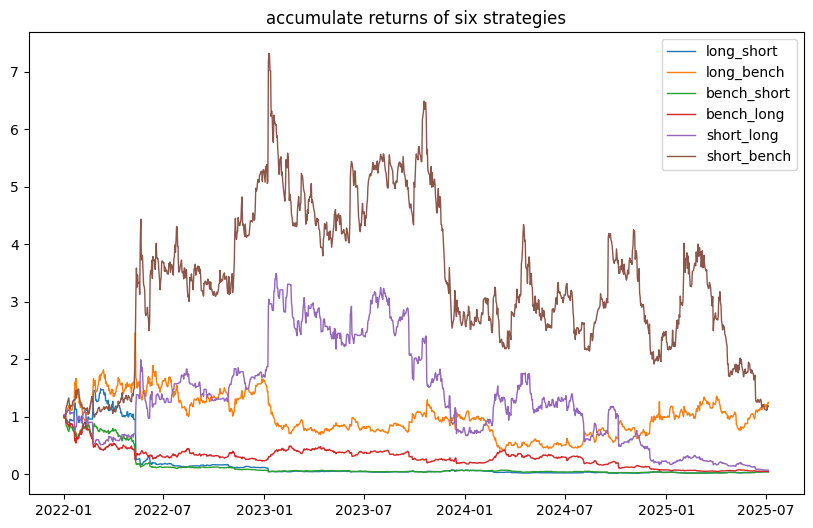

long_short: 
ann_return = -0.2817  sharpe = -0.0463  maxdd = 0.9918  calmar_ratio = -0.284  

long_bench: 
ann_return = 10.9352  sharpe = 2.4763  maxdd = 0.8329  calmar_ratio = 13.1297  

bench_short: 
ann_return = -11.2169  sharpe = -2.4402  maxdd = 0.9862  calmar_ratio = -11.3739  

bench_long: 
ann_return = -10.9352  sharpe = -2.4763  maxdd = 0.9593  calmar_ratio = -11.3992  

short_long: 
ann_return = 0.2817  sharpe = 0.0463  maxdd = 0.9813  calmar_ratio = 0.287  

short_bench: 
ann_return = 11.2169  sharpe = 2.4402  maxdd = 0.8487  calmar_ratio = 13.2168  



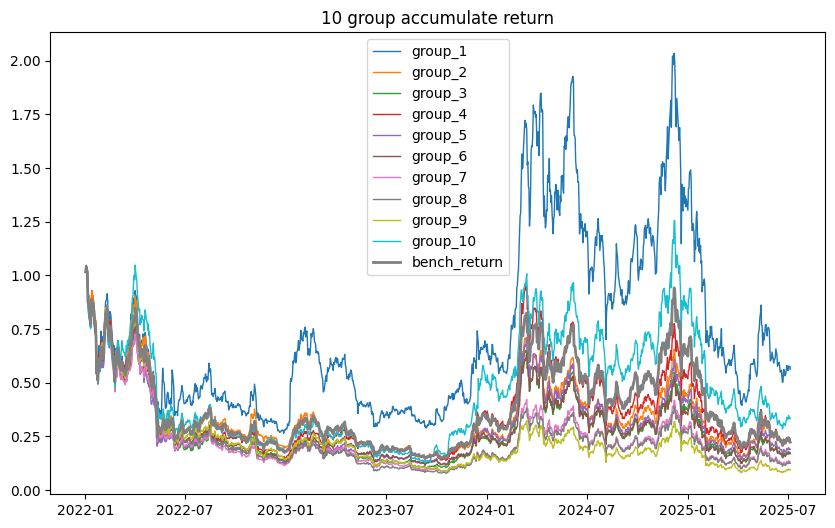

group_1: 
sharpe = 1.9185  ann_return = 10.5684  maxdd = 0.8063  calmar_ratio = 13.1077  

group_2: 
sharpe = 0.2424  ann_return = 1.1317  maxdd = 0.8587  calmar_ratio = 1.3179  

group_3: 
sharpe = -0.2777  ann_return = -1.2712  maxdd = 0.904  calmar_ratio = -1.4062  

group_4: 
sharpe = 0.125  ann_return = 0.5661  maxdd = 0.8681  calmar_ratio = 0.652  

group_5: 
sharpe = -0.1157  ann_return = -0.5319  maxdd = 0.8874  calmar_ratio = -0.5994  

group_6: 
sharpe = -0.306  ann_return = -1.4011  maxdd = 0.8899  calmar_ratio = -1.5744  

group_7: 
sharpe = -0.7245  ann_return = -3.2872  maxdd = 0.9188  calmar_ratio = -3.5776  

group_8: 
sharpe = -0.8081  ann_return = -3.6638  maxdd = 0.9252  calmar_ratio = -3.9599  

group_9: 
sharpe = -1.2503  ann_return = -5.6474  maxdd = 0.9233  calmar_ratio = -6.1163  

group_10: 
sharpe = 0.8768  ann_return = 4.2483  maxdd = 0.8785  calmar_ratio = 4.836  



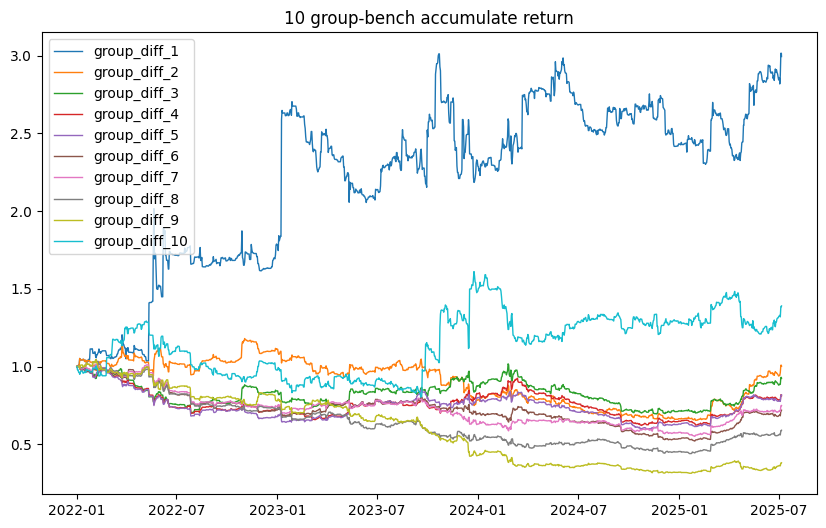

group_diff_1: 
sharpe = 4.1307  ann_return = 10.0991  maxdd = 0.2812  calmar_ratio = 35.9133  

group_diff_2: 
sharpe = 0.5809  ann_return = 0.6655  maxdd = 0.4458  calmar_ratio = 1.4927  

group_diff_3: 
sharpe = -0.0743  ann_return = -0.0715  maxdd = 0.3162  calmar_ratio = -0.2262  

group_diff_4: 
sharpe = -1.2124  ann_return = -1.0349  maxdd = 0.381  calmar_ratio = -2.7166  

group_diff_5: 
sharpe = -1.1782  ann_return = -1.0012  maxdd = 0.4046  calmar_ratio = -2.4744  

group_diff_6: 
sharpe = -2.2135  ann_return = -1.8703  maxdd = 0.4808  calmar_ratio = -3.8899  

group_diff_7: 
sharpe = -1.8407  ann_return = -1.5798  maxdd = 0.4571  calmar_ratio = -3.4558  

group_diff_8: 
sharpe = -3.3372  ann_return = -3.1231  maxdd = 0.5786  calmar_ratio = -5.3978  

group_diff_9: 
sharpe = -5.4225  ann_return = -5.9216  maxdd = 0.6995  calmar_ratio = -8.4652  

group_diff_10: 
sharpe = 2.0687  ann_return = 3.779  maxdd = 0.3782  calmar_ratio = 9.9924  



In [16]:
factors_np = factors[columns].to_numpy()
ret_np = ret[columns].to_numpy()

def factor_stats(n, pnl):
    net_value = (1 + pnl).cum_prod()
    sharpe = n ** 0.5 * pnl.mean() / pnl.std()
    ann_return = n * pnl.mean()
    maxdd = (-(net_value / net_value.cum_max() - 1)).max()
    calmar_ratio = ann_return / maxdd

    print("ann_return =", round(ann_return, 4), end='  ')
    print("sharpe =", round(sharpe, 4), end='  ')
    print("maxdd =", round(maxdd, 4), end='  ')
    print("calmar_ratio =", round(calmar_ratio, 4), end='  ')


percentage = 0.5
quantiles = np.nanquantile(factors_np, [1 - percentage, percentage], axis=1)

f = lambda x: quantiles[x][:, None].repeat(factors_np.shape[1], axis=-1)
long_quantile, short_quantile = f(0), f(1)

# return before fee
long = np.nan_to_num(np.nan_to_num(ret_np * (factors_np > long_quantile), 0.0).sum(axis=1) / (factors_np > long_quantile).sum(axis=1) , 0.0)
short = np.nan_to_num(np.nan_to_num(ret_np * (factors_np < long_quantile), 0.0).sum(axis=1) / (factors_np < long_quantile).sum(axis=1) , 0.0)
bench = np.nan_to_num(np.nanmean(ret_np, axis=1), 0.0)

# return after fee
long_fee = pl.Series(long - 2 * commission)
short_fee = pl.Series(short - 2 * commission)
bench_fee = pl.Series(bench - 2 * commission)

long_short = pl.Series(long - short - 2 * commission)
long_bench = pl.Series(long - bench - 2 * commission)
bench_short = pl.Series(bench - short - 2 * commission)
bench_long = pl.Series(bench - long - 2 * commission)
short_long = pl.Series(short - long - 2 * commission)
short_bench = pl.Series(short - bench - 2 * commission)


long_cum = (1 + long_fee).cum_prod()
short_cum = (1 + short_fee).cum_prod()
bench_cum = (1 + bench_fee).cum_prod()

long_short_cum = (1 + long_short).cum_prod()
long_bench_cum = (1 + long_bench).cum_prod()
bench_short_cum = (1 + bench_short).cum_prod()
bench_long_cum = (1 + bench_long).cum_prod()
short_long_cum = (1 + short_long).cum_prod()
short_bench_cum = (1 + short_bench).cum_prod()


plt.figure(figsize=(10, 6))
plt.plot(factors["open_time"].to_pandas(), long_cum.to_pandas(), label='long', linewidth=1)
plt.plot(factors["open_time"].to_pandas(), short_cum.to_pandas(), label='short', linewidth=1)
plt.plot(factors["open_time"].to_pandas(), bench_cum.to_pandas(), label='bench', linewidth=2, color="gray")
plt.title("accumulate long & short & bench")
plt.legend()
plt.show()

# 因子评价指标
n = 365 * 24 #小时
# n = 365 #天
# n = 52 #周
print("long: ")
factor_stats(n, long_fee)
print("\n")
print("short: ")
factor_stats(n, short_fee)
print("\n")
print("bench: ")
factor_stats(n, bench_fee)
print("\n")


plt.figure(figsize=(10, 6))
plt.plot(factors["open_time"].to_pandas(), long_short_cum.to_pandas(), label='long_short', linewidth=1)
plt.plot(factors["open_time"].to_pandas(), long_bench_cum.to_pandas(), label='long_bench', linewidth=1)
plt.plot(factors["open_time"].to_pandas(), bench_short_cum.to_pandas(), label='bench_short', linewidth=1)
plt.plot(factors["open_time"].to_pandas(), bench_long_cum.to_pandas(), label='bench_long', linewidth=1)
plt.plot(factors["open_time"].to_pandas(), short_long_cum.to_pandas(), label='short_long', linewidth=1)
plt.plot(factors["open_time"].to_pandas(),short_bench_cum.to_pandas(), label='short_bench', linewidth=1)
plt.title("accumulate returns of six strategies")
plt.legend()
plt.show()


# 因子评价指标
print("long_short: ")
factor_stats(n, long_short)
print("\n")

print("long_bench: ")
factor_stats(n, long_bench)
print("\n")

print("bench_short: ")
factor_stats(n, bench_short)
print("\n")

print("bench_long: ")
factor_stats(n, bench_long)
print("\n")

print("short_long: ")
factor_stats(n, short_long)
print("\n")

print("short_bench: ")
factor_stats(n, short_bench)
print("\n")

###################################################################################################################

quantiles = np.nanquantile(factors_np, np.linspace(0, 1, 11), axis=1)
total_count = np.count_nonzero(~np.isnan(factors_np), axis=1)
f = lambda x: quantiles[x][:, None].repeat(factors_np.shape[1], axis=-1)

#bench_return = np.nan_to_num(ret_np, 0.0).mean(axis=1)
bench_return = np.nan_to_num(np.nanmean(ret_np, axis=1), 0.0)
bench_return_fee = np.nan_to_num(np.nanmean(ret_np, axis=1), 0.0) - 2 * commission
group_return = np.zeros((factors_np.shape[0], 10))
group_diff_return = np.zeros((factors_np.shape[0], 10))

for i in range(1, 11):
    # 计算在当前分位数范围内的总收益。如果因子值位于该分位数的范围内，则相应的收益被计入总和。
    ret_sum = np.nan_to_num(ret_np * (f(i-1) <= factors_np) * (factors_np <= f(i)), 0.0).sum(axis=1)
    # 计算当前分位数范围内的有效数据点数
    ret_count = np.nan_to_num((f(i-1) <= factors_np) * (factors_np <= f(i)), 0.0).sum(axis=1)
    group_return[:, i-1] = ret_sum / ret_count - 2 * commission 
    group_diff_return[:, i-1] = ret_sum / ret_count - bench_return - 2 * commission


group_return = np.nan_to_num(group_return)
group_diff_return = np.nan_to_num(group_diff_return)


plt.figure(figsize=(10, 6))
plt.title("10 group accumulate return")
for i in range(10):
    plt.plot(factors["open_time"].to_pandas(), np.cumprod(1 + group_return[:, i]), label=f"group_{i+1}", linewidth=1)
plt.plot(factors["open_time"].to_pandas(), np.cumprod(1 + bench_return_fee), label=f"bench_return", linewidth=2, color="gray")
plt.legend()
plt.show()

for i in range(10):
    print(f"group_{i+1}: ")
    net_value = np.cumprod(1 + group_return[:, i])
    sharpe = n ** 0.5 * group_return[:, i].mean() / group_return[:, i].std()
    ann_return = n * group_return[:, i].mean()
    maxdd = (-(net_value / np.maximum.accumulate(net_value) - 1)).max()
    calmar_ratio = ann_return / maxdd
    print("sharpe =", round(sharpe, 4), end='  ')
    print("ann_return =", round(ann_return, 4), end='  ')
    print("maxdd =", round(maxdd, 4), end='  ')
    print("calmar_ratio =", round(calmar_ratio, 4), end='  ')
    print("\n")


plt.figure(figsize=(10, 6))
plt.title("10 group-bench accumulate return")
for i in range(10):
    plt.plot(factors["open_time"].to_pandas(), np.cumprod(1 + group_diff_return[:, i]), label=f"group_diff_{i+1}", linewidth=1)
plt.legend()
plt.show()

for i in range(10):
    print(f"group_diff_{i+1}: ")
    net_value = np.cumprod(1 + group_diff_return[:, i])
    sharpe = n ** 0.5 * group_diff_return[:, i].mean() / group_diff_return[:, i].std()
    ann_return = n * group_diff_return[:, i].mean()
    maxdd = (-(net_value / np.maximum.accumulate(net_value) - 1)).max()
    calmar_ratio = ann_return / maxdd
    print("sharpe =", round(sharpe, 4), end='  ')
    print("ann_return =", round(ann_return, 4), end='  ')
    print("maxdd =", round(maxdd, 4), end='  ')
    print("calmar_ratio =", round(calmar_ratio, 4), end='  ')
    print("\n")